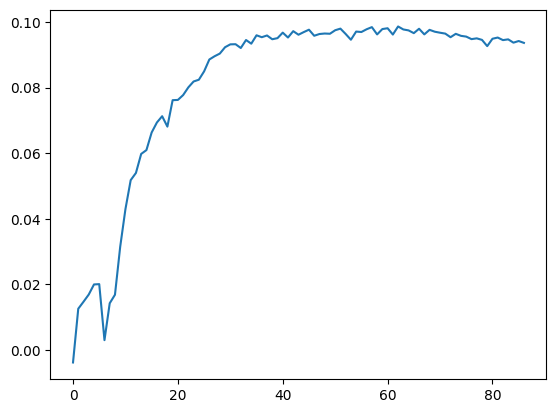

In [15]:
plt.plot(val_corrs)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from os import path

from torch import nn
from torch.nn import functional as F
from torch.nn.functional import scaled_dot_product_attention
from torch.nn.attention import SDPBackend, sdpa_kernel
from tqdm import tqdm
from einops import rearrange
from torch.optim import AdamW, Adam

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from omegaconf import OmegaConf, open_dict
from experanto.datasets import ChunkDataset, SimpleChunkedDataset
from experanto.utils import LongCycler, MultiEpochsDataLoader

In [2]:
# additional packages
# pip install hiera-transformer
# pip install -U pytorch_warmup

# Hyperparameters

In [3]:
video_size = [72, 128]
chunk_size = 8
dim_head = 64
num_heads = 16

### get dataloaders

In [4]:
from experanto.dataloaders import get_multisession_dataloader

from experanto.configs import DEFAULT_CONFIG as cfg
paths = ['dynamic29513-3-5-Video-full',
         'dynamic29514-2-9-Video-full',
         'dynamic29755-2-8-Video-full',
         'dynamic29647-19-8-Video-full',
         'dynamic29156-11-10-Video-full',
         'dynamic29623-4-9-Video-full',
         'dynamic29515-10-12-Video-full',
         'dynamic29234-6-9-Video-full',
         'dynamic29712-5-9-Video-full',
         'dynamic29228-2-10-Video-full'
        ]
full_paths = [path.join("/data/mouse_polly/", f) for f in paths]

In [ ]:
cfg.dataset.global_chunk_size = 8
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.sample_stride = 8
cfg.dataset.modality_config.screen.include_blanks=True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}
cfg.dataset.modality_config.screen.transforms.Resize.size = video_size

cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=128
cfg.dataloader.pin_memory=True
cfg.dataloader.shuffle=True

train_dl = get_multisession_dataloader(full_paths, cfg)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### get Hiera backbone

In [ ]:
# pip install hiera-transformer
from hiera import Hiera
tiny_hiera = Hiera(input_size=(chunk_size, video_size[0], video_size[1]),
                     num_heads=1,
                     embed_dim=96,
                     stages=(2, 2), # 4 transformer layers 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(1, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 8, 8),
                     patch_stride=(2, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)

tiny_hiera = tiny_hiera.cuda().to(torch.bfloat16);
example_input = torch.ones(8,1,8,72, 128).to("cuda", torch.bfloat16)
out = tiny_hiera(example_input, return_intermediates=True);
hiera_output = out[-1][-1]
hiera_output.shape # (b, t, h, w, c): (8, 4, 9, 16, 192)


# Model definition

In [ ]:
class MouseHieraSmall(nn.Module):
    def __init__(self,
                 backbone,
                 dls,
                 chunk_size,
                 dim=192,
                 dim_head=32,
                 num_heads=4):
        super().__init__()
        self.backbone=backbone
        self.num_heads=num_heads
        self.dim_head=dim_head
        self.wk = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.wv = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.neuron_proj = nn.Linear(dim_head * num_heads, chunk_size, bias=False)
        self.readout = nn.ModuleDict()
        self.activation = nn.Softplus(beta=0.5) # probably a much better activation than ELU+1
        for k, v in dls.loaders.items():
            n_neurons = next(iter(v))["responses"].shape[-1]
            self.readout[k] = IndexedLinearReadout(n_neurons, 
                                                   in_features=dim_head*num_heads,
                                                   dim_head=dim_head, 
                                                   num_heads=num_heads, 
                                                  )
            
    def forward(self, x, key):
        x = self.backbone(x, return_intermediates=True)[1][-1]
        b, t, h, w, d = x.shape
        x = x.view(b, -1, d) # (B, t*h*w, D)
        k, v = self.wk(x), self.wv(x)
        q = self.readout[key].query
        n = q.shape[2] # number of neurons
        q = q.repeat(b, 1, 1, 1) # repeat query for number of batches
        k = k.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2) # (B, H, S, D)
        v = v.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2) # (B, H, S, D)
        # remove if kernel is not available
        with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
            o = F.scaled_dot_product_attention(q, k, v)
            
        # (B, H, S, D) -> (B, N, D), with N = num_neurons
        o = o.transpose(1,2).contiguous().view(b, -1, self.num_heads * self.dim_head)
        o = self.neuron_proj(o) # (B, N, D) -> (B, N, t)
        o = o + self.readout[key].bias
        o = self.activation(o)
        return o

# Readout 

In [ ]:
class IndexedLinearReadout(nn.Module):
    """
    Readout module for MTM models with selectable weights based on 
    input IDs. Based on :class:`torch.nn.Linear`.
    """
    def __init__(
        self,
        unique_ids: int,
        in_features: int = 384,
        dim_head=32,
        num_heads=4,
        bias: bool = True,
        device="cuda",
        dtype=torch.float32,
        init_std: float = 0.02,
    ):
        super().__init__()
        factory_kwargs = {"device": device, "dtype": dtype}
        self.unique_ids = unique_ids
        self.in_features = in_features
        self.init_std = init_std
        self.query = nn.Parameter(
            torch.empty(1, num_heads, unique_ids, dim_head, **factory_kwargs)
        )
        if bias:
            self.bias = nn.Parameter(
                torch.empty(1, unique_ids, 1, **factory_kwargs)
            )
        else:
            self.register_parameter('bias', None)
        self.init_weights()

    def init_weights(self, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.query,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        if self.bias is not None:
            self.bias.data.zero_()

### Build Model

In [ ]:
backbone_dim = hiera_output[-1][-1].shape[-1]
model = MouseHieraSmall(backbone=tiny_hiera, 
                        dls=train_dl, 
                        chunk_size=chunk_size,
                        dim=backbone_dim, 
                        dim_head=dim_head,
                        num_heads=num_heads)

### performance boosts

In [ ]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')

torch._dynamo.config.cache_size_limit = 32
model = torch.compile(model).cuda().to(torch.bfloat16)

# Trainer

In [ ]:
# pip install -U pytorch_warmup
import pytorch_warmup as warmup

n_epochs = 5
lr = 1.0e-3

criteria = nn.PoissonNLLLoss(log_input=False, reduction='mean')
opt = AdamW(model.parameters(), lr=lr, weight_decay=0.1,)
warmup_scheduler = warmup.UntunedLinearWarmup(opt)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt,
                                                          T_max=5e5, 
                                                          eta_min=1e-5)

# train - simple

In [12]:
# the first 10 batches are slow because torch is compiling the model for each new input shape

for _ in range(n_epochs):
    for i, (key, batch) in tqdm(enumerate(train_dl)):
        videos = batch["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        responses = batch["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        out = model(videos, key);
        loss = criteria(out.transpose(1,2), responses)
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), gradient_clip_value,)
        opt.step()
        opt.zero_grad()
        with warmup_scheduler.dampening():
            lr_scheduler.step()
            
    # after each epoch, the times can be shuffled so there are new random starting points for all chunks
    for dataloader in train_dl.loaders.values():
        dataloader.dataset.shuffle_valid_screen_times()

8it [01:13,  9.51s/it]W1025 00:40:25.568000 42943 torch/_dynamo/convert_frame.py:844] [0/8] torch._dynamo hit config.cache_size_limit (8)
W1025 00:40:25.568000 42943 torch/_dynamo/convert_frame.py:844] [0/8]    function: 'forward' (/tmp/ipykernel_42943/2099902904.py:24)
W1025 00:40:25.568000 42943 torch/_dynamo/convert_frame.py:844] [0/8]    last reason: 0/0: L['key'] == '29513-3-5'                                     
W1025 00:40:25.568000 42943 torch/_dynamo/convert_frame.py:844] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1025 00:40:25.568000 42943 torch/_dynamo/convert_frame.py:844] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
2140it [02:28, 14.39it/s]
2140it [01:14, 28.58it/s]
2140it [01:14, 28.92it/s]
2140it [01:13, 28.94it/s]
2140it [01:12, 29.36it/s]


# train messy

In [ ]:
from experanto.configs import DEFAULT_CONFIG as cfg
cfg.dataset.global_chunk_size = 8
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.include_blanks=False
cfg.dataset.modality_config.screen.sample_stride=8
cfg.dataset.modality_config.screen.valid_condition = {"tier": "oracle"}
cfg.dataset.modality_config.screen.transforms.Resize.size = video_size


cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=32
cfg.dataloader.pin_memory=True
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
val_dl = get_multisession_dataloader(full_paths[3:4], cfg)

In [ ]:
def val_step():
    targets, predictions = [],[]
    with torch.no_grad():
        for i, (k, b) in tqdm(enumerate(val_dl)):
            videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
            responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
            out = model(videos, k);
            predictions.append(out.transpose(1,2).to(torch.float32).cpu().numpy())
            targets.append(responses.to(torch.float32).cpu().numpy())
    r1 = np.vstack(np.vstack(predictions))
    r2 = np.vstack(np.vstack(targets))
    cs = []
    for n in range(7000):
        c =  np.corrcoef(r1[...,n].flatten(), r2[...,n].flatten(), )[0,1]
        cs.append(c)
    val_corrs = np.stack(cs).mean()
    return val_corrs

In [ ]:
patience = 0
max_objective = 0
losses, corrs, lrs, val_corrs = [], [], [], []
for train_loop in range(1000):
    current_objective = val_step()
    if train_loop > 20:
        max_objective = np.max(np.array(val_corrs[:-1])[~np.isnan(val_corrs[:-1])])
    if current_objective < max_objective:
        patience += 1
    else:
        patience = 0
    if patience >=25:
        break
    val_corrs.append(current_objective)
    print(val_corrs)
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        out = model(videos, k);
        loss = criteria(out.transpose(1,2), responses)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=2)
        opt.step()
        opt.zero_grad()
        
        losses.append(loss.item())
        with warmup_scheduler.dampening():
            lr_scheduler.step()
        
        if i % 10 ==0:
            r2 = responses.to(torch.float32).cpu().numpy().flatten()
            r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
            corrs.append(np.corrcoef(r1,r2)[0,1].item())
            lrs.append(opt.param_groups[0]['lr'])
        if i % 100 ==0:
            print(np.corrcoef(r1,r2)[0,1].item())
            print(opt.param_groups[0]['lr'])
    for k, v in train_dl.loaders.items():
        v.dataset.shuffle_valid_screen_times()